In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import os
import squidpy as sq
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
import catboost
import json


from tqdm import tqdm
import sys
sys.path.append('/Users/rssantanu/Desktop/codebase/constrained_FM')


import argparse

max_rows = 1000000
pd.set_option('display.max_rows', max_rows)
pd.set_option('display.max_columns', max_rows)
pd.set_option('display.width', max_rows)


/Users/rssantanu/anaconda3/envs/torch_flow_matching/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/rssantanu/anaconda3/envs/torch_flow_matching/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [6]:
# scRNA_sm = ad.read_h5ad(os.path.join('/Users/rssantanu/Desktop/codebase/constrained_FM', 'datasets/h5ad_processed_datasets', 'GSE232025_stereoseq.h5ad'))
# scRNA_sm_22k = ad.read_h5ad(os.path.join('/Users/rssantanu/Desktop/codebase/constrained_FM', 'datasets/h5ad_processed_datasets', 'GSE232025_stereoseq_22k_genes.h5ad'))
# scRNA_sm_10k = ad.read_h5ad(os.path.join('/Users/rssantanu/Desktop/codebase/constrained_FM', 'datasets/h5ad_processed_datasets', 'GSE232025_stereoseq_10k_genes.h5ad'))

scRNA_liver= ad.read_h5ad('/Users/rssantanu/Desktop/codebase/constrained_FM/datasets/h5ad_processed_datasets/GSE092025_liver_g_10000_nzp_0.006.h5ad')


# scRNA_mouse = ad.read_h5ad(os.path.join('/Users/rssantanu/Desktop/codebase/constrained_FM', 'datasets/h5ad_processed_datasets', 'GSE312025_MSmouse.h5ad'))
# scRNA_liver_visium = ad.read_h5ad(os.path.join('/Users/rssantanu/Desktop/codebase/constrained_FM', 'datasets/h5ad_processed_datasets', 'GSE092025_liver_regeneration_visium.h5ad'))

/Users/rssantanu/anaconda3/envs/torch_flow_matching/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [7]:
import liana as li

In [9]:
# scRNA= scRNA_sm
# scRNA= scRNA_sm_10k
# scRNA= scRNA_sm_22k
# scRNA= scRNA_mouse
scRNA= scRNA_liver

In [10]:
scRNA

AnnData object with n_obs × n_vars = 9266 × 10000
    obs: 'Spot_barcode', 'Mouse', 'Time_point', 'celltype', 'visium_coor_x', 'visium_coor_y', 'sample', 'timepoint', 'day', 'color'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'LR_pattern_pairs', 'hvg', 'neighbors', 'pca', 'umap'
    obsm: 'LR_pattern', 'X_pca', 'X_umap', 'local_mean_X_pca', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities'

In [11]:
# import re

# # def extract_symbol(name):
# #     # Try to find a gene symbol in the string
# #     # Look for patterns like 'SYMBOL[nr]' or 'SYMBOL[hs]' or 'SYMBOL |'
# #     match = re.search(r'([A-Z0-9\-]+)(?:\[.*?\])?\s*\|', name)
# #     if match:
# #         return match.group(1)
# #     # If not found, try to find a symbol before a space or bracket
# #     match = re.match(r'([A-Z0-9\-]+)', name)
# #     if match:
# #         return match.group(1)
# #     return None

# import re
# scRNA.var["gene_symbol_original"] = scRNA.var_names
# def clean_name(name):
#     # keep leftmost alias before '|'
#     primary = name.split("|")[0]
#     # remove [hs], [nr], etc.
#     primary = re.sub(r"\[.*?\]", "", primary)
#     return primary.strip()
# scRNA.var_names = [clean_name(x) for x in scRNA.var_names]
# scRNA.var_names_make_unique()


# # Apply to your var_names
# symbols = [extract_symbol(x) for x in scRNA.var_names]
# scRNA.var['gene_symbol'] = symbols
# # Filter out None or nan
# scRNA = scRNA[:, [s is not None and s != 'nan' for s in symbols]]
# scRNA.var_names = scRNA.var['gene_symbol']

In [12]:
# scRNA.layers['counts'] = scRNA.X.copy()
# sc.pp.normalize_total(scRNA, target_sum=1e4)
# sc.pp.log1p(scRNA)


In [13]:
li.ut.spatial_neighbors(scRNA, bandwidth=200, cutoff=0.1, kernel='gaussian', set_diag=True)

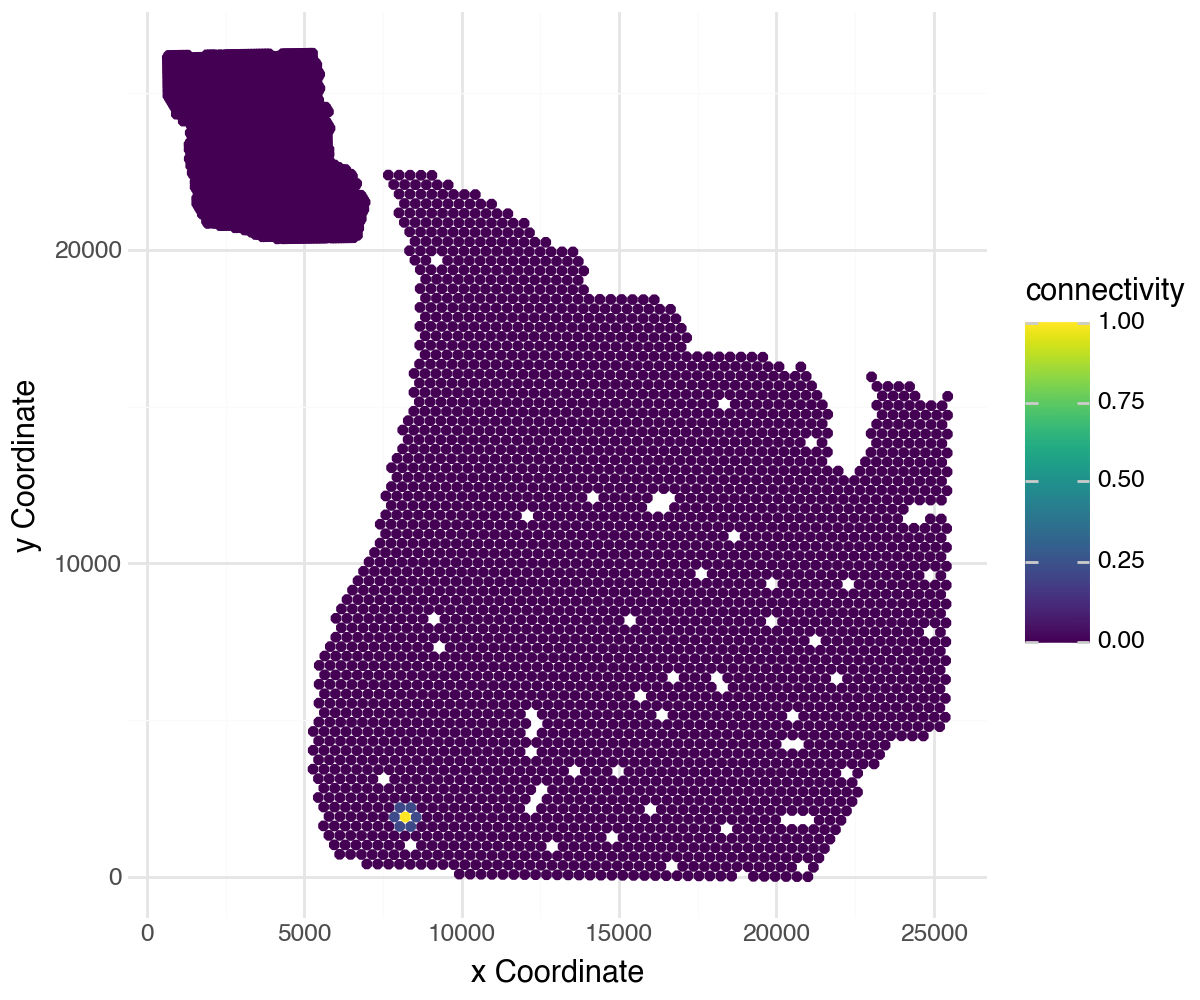

In [15]:
li.pl.connectivity(scRNA, idx=1000, size=1.3, figure_size=(6, 5))

In [ ]:
# import requests
# import pandas as pd

# # Define the species and Ensembl server
# species = 'ambystoma_mexicanum'  # Example for axolotl
# ensembl_server = "https://rest.ensembl.org"

# # Fetch orthologs from Ensembl
# def fetch_orthologs(human_gene):
#     ext = f"/homology/id/{human_gene}?target_species={species}&type=orthologues"
#     r = requests.get(ensembl_server + ext, headers={"Content-Type": "application/json"})
#     if not r.ok:
#         r.raise_for_status()
#     return r.json()

# # Example: Fetch orthologs for a list of human genes
# human_genes = ['BRCA1', 'TP53', 'EGFR']  # Replace with your list
# orthologs = []
# for gene in human_genes:
#     data = fetch_orthologs(gene)
#     for homology in data['data'][0]['homologies']:
#         if homology['target']['species'] == species:
#             orthologs.append({
#                 'source': gene,
#                 'target': homology['target']['id']
#             })

# # Create a DataFrame for mapping
# map_df = pd.DataFrame(orthologs)
# print(map_df.head())


In [16]:
import liana as li
import pandas as pd

# Check if 'gene_symbol' column exists in scRNA.var
if 'gene_symbol' in scRNA.var.columns:
    print("Gene symbols found in 'gene_symbol' column.")
    scRNA.var_names = scRNA.var['gene_symbol']
else:
    print("No 'gene_symbol' column found. Please ensure your data has the correct gene symbols.")

# Check overlap with the resource
resource = li.resource.select_resource('consensus')
resource_genes = set(resource['ligand'].tolist() + resource['receptor'].tolist())
your_genes = set(scRNA.var_names.tolist())

intersection = resource_genes.intersection(your_genes)
print(f"Number of genes that match: {len(intersection)}")
print(f"Proportion matching: {len(intersection)/len(resource_genes):.3f}")

if len(intersection) == 0:
    print("No matching genes found. Consider converting your gene symbols to human gene symbols.")

No 'gene_symbol' column found. Please ensure your data has the correct gene symbols.
Number of genes that match: 7
Proportion matching: 0.003


In [17]:
scRNA.var_names

Index(['Gm19938', 'Tcea1', 'Rgs20', 'Atp6v1h', 'Adhfe1', '2610203C22Rik', 'Vxn', '1700034P13Rik', 'Sgk3', 'Snhg6',
       ...
       'mt-Nd5', 'mt-Nd6', 'mt-Cytb', 'Csprs', 'Vamp7', 'Spry3', 'Tmlhe', 'CR974586.4', '4933409K07Rik', 'AC149090.1'], dtype='object', length=10000)

In [21]:
lrdata = li.mt.bivariate(scRNA,
                resource_name='consensus', # NOTE: uses HUMAN gene symbols!
                local_name='cosine', # Name of the function
                global_name="morans", # Name global function
                n_perms=100, # Number of permutations to calculate a p-value
                mask_negatives=False, # Whether to mask LowLow/NegativeNegative interactions
                add_categories=True, # Whether to add local categories to the results
                nz_prop=0.006, # Minimum expr. proportion for ligands/receptors and their subunits
                use_raw=False,
                verbose=True
                )

Using `.X`!
/Users/rssantanu/anaconda3/envs/torch_flow_matching/lib/python3.10/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/Users/rssantanu/anaconda3/envs/torch_flow_matching/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/Users/rssantanu/anaconda3/envs/torch_flow_matching/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Make sure that normalized counts are passed!
Using resource `consensus`.
/Users/rssantanu/anaconda3/envs/torch_flow_matching/lib/python3.10/site-packages/anndata/_core/storage.py:48: FutureWarning: AnnData previously had undefined behavior around matrices of type <class 'scipy.sparse._coo.coo_matrix'>.In 0.12, passing in this type will throw an error. Please convert to a

In [22]:
lrdata

AnnData object with n_obs × n_vars = 9266 × 1
    obs: 'Spot_barcode', 'Mouse', 'Time_point', 'celltype', 'visium_coor_x', 'visium_coor_y', 'sample', 'timepoint', 'day', 'color'
    var: 'ligand', 'receptor', 'ligand_means', 'ligand_props', 'receptor_means', 'receptor_props', 'morans', 'morans_pvals', 'mean', 'std'
    uns: 'LR_pattern_pairs', 'hvg', 'neighbors', 'pca', 'umap'
    obsm: 'LR_pattern', 'X_pca', 'X_umap', 'local_mean_X_pca', 'spatial'
    layers: 'cats', 'pvals'
    obsp: 'connectivities', 'distances', 'spatial_connectivities'

In [23]:
(lrdata.var.sort_values("mean", ascending=False))

,ligand,receptor,ligand_means,ligand_props,receptor_means,receptor_props,morans,morans_pvals,mean,std
interaction,,,,,,,,,,
F7^F3,F7,F3,1.346749,0.63188,0.02493,0.023851,0.024137,0.0,0.088604,0.103171


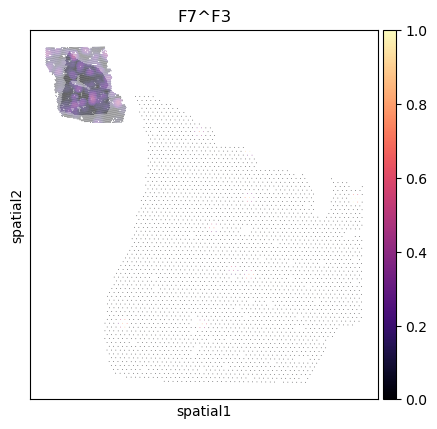

In [24]:
# Provide spot_size directly
sc.pl.spatial(lrdata, color=['F7^F3'], size=1.4, vmax=1, cmap='magma', spot_size=40)  # Adjust spot_size as needed

In [25]:
# # for all the days

# li.method.rank_aggregate(
#     adata=scRNA,
#     groupby='celltype',
#     resource_name='consensus',
#     use_raw=False,         # <--- add this line
#     verbose=True
# )

lrdata_by_day= []
nz_prop= 0.006
for stage in scRNA.obs['day'].unique():
    adata_stage = scRNA[scRNA.obs['day'] == stage].copy()
    lrdata = li.mt.bivariate(adata_stage,
                resource_name='consensus', # NOTE: uses HUMAN gene symbols!
                local_name='cosine', # Name of the function
                global_name="morans", # Name global function
                n_perms=100, # Number of permutations to calculate a p-value
                mask_negatives=False, # Whether to mask LowLow/NegativeNegative interactions
                add_categories=True, # Whether to add local categories to the results
                nz_prop=nz_prop, # Minimum expr. proportion for ligands/receptors and their subunits
                use_raw=False,
                verbose=True
                )
    # Save or analyze results for this stage
    # adata_stage.uns['liana_res'].to_csv(f'liana_results_stage_{stage}.csv')
    lrdata_by_day.append(lrdata)



Using `.X`!
/Users/rssantanu/anaconda3/envs/torch_flow_matching/lib/python3.10/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
890 features of mat are empty, they will be removed.
Make sure that normalized counts are passed!
Using resource `consensus`.
/Users/rssantanu/anaconda3/envs/torch_flow_matching/lib/python3.10/site-packages/anndata/_core/storage.py:48: FutureWarning: AnnData previously had undefined behavior around matrices of type <class 'scipy.sparse._coo.coo_matrix'>.In 0.12, passing in this type will throw an error. Please convert to a supported type.Continue using for this minor version at your own risk.
100%|██████████| 100/100 [00:00<00:00, 727.35it/s]
Using `.X`!
/Users/rssantanu/anaconda3/envs/torch_flow_matching/lib/python3.10/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
376 features of mat are empty, they will 

In [26]:
for lrdata in lrdata_by_day:
    # print(lrdata.var.sort_values("mean", ascending=False))
    print(len(lrdata.var.sort_values("mean", ascending=False)))

# for stage in scRNA.obs['day'].unique():
#     adata_stage = scRNA[scRNA.obs['day'] == stage].copy()
#     print(adata_stage.X.shape)

1
1
1


In [27]:
lrdata_by_day[0].var.sort_values("mean", ascending=False)

,ligand,receptor,ligand_means,ligand_props,receptor_means,receptor_props,morans,morans_pvals,mean,std
interaction,,,,,,,,,,
F7^F3,F7,F3,0.36,0.280976,0.006504,0.006179,0.039128,0.0,0.010778,0.083427


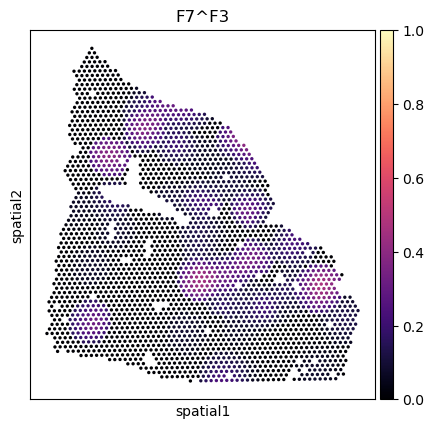

In [28]:
sc.pl.spatial(lrdata_by_day[2], color=['F7^F3'], size=1.4, vmax=1, cmap='magma', spot_size=40)  # Adjust spot_size as needed

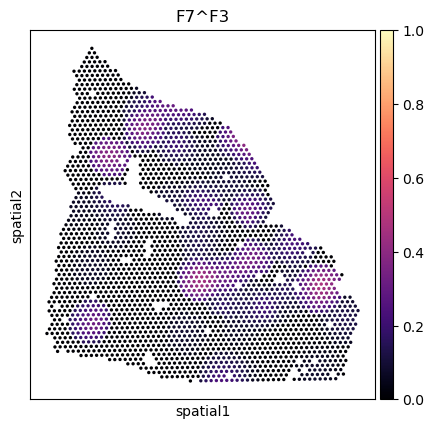

In [55]:
sc.pl.spatial(lrdata_by_day[2], color=['F7^F3'], size=1.4, vmax=1, cmap='magma', spot_size=40)  # Adjust spot_size as needed

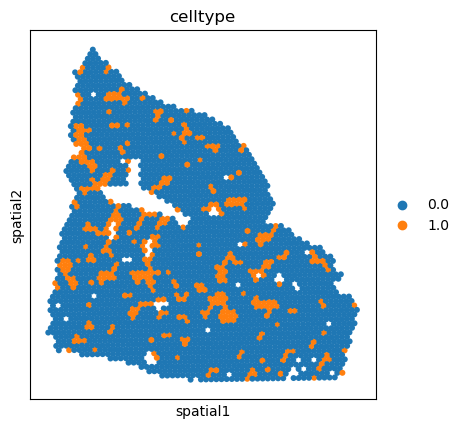

In [56]:
sc.pl.spatial(lrdata_by_day[2], spot_size = 100, color="celltype")

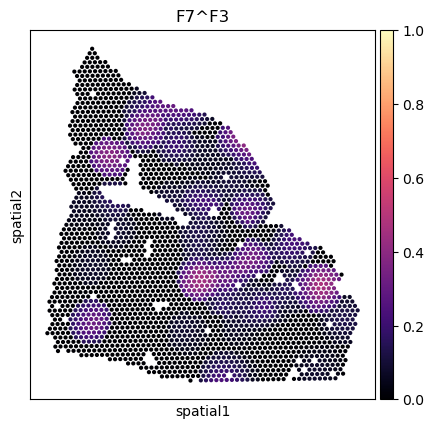

In [53]:
sc.pl.spatial(lrdata_by_day[2], color=['F7^F3'], size=1.4, vmax=1, cmap='magma', spot_size=50)  # Adjust spot_size as needed

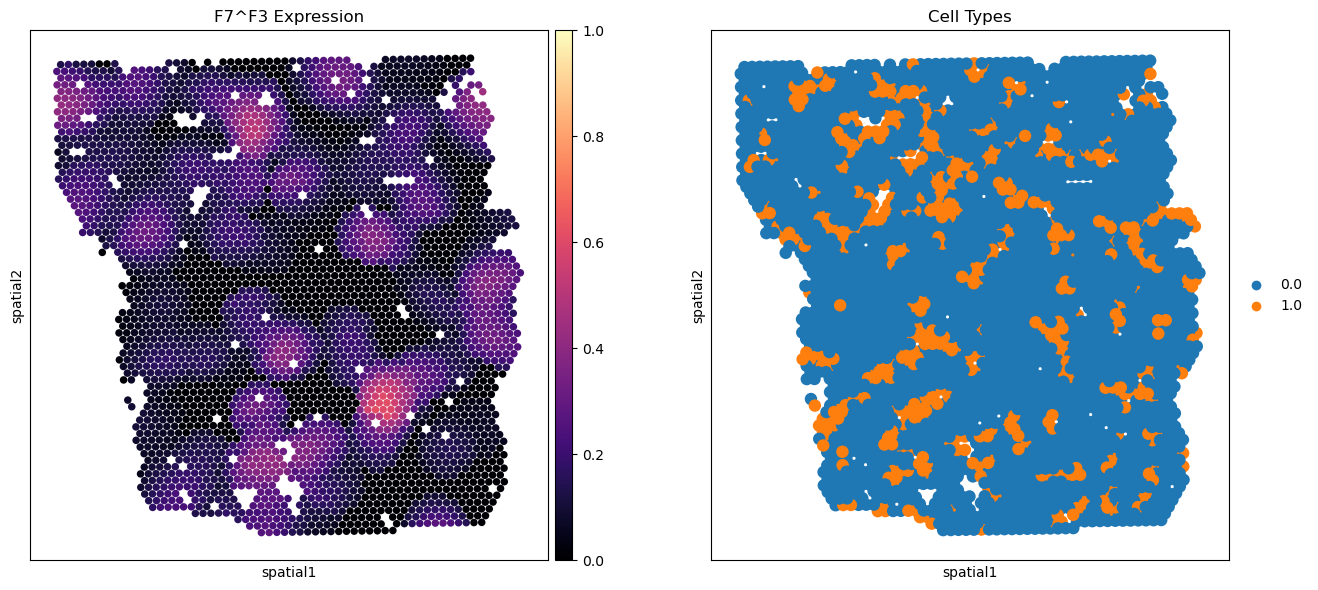

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# First plot
sc.pl.spatial(lrdata_by_day[1], color=['F7^F3'], size=1.4, vmax=1, cmap='magma', 
              spot_size=60, ax=axes[0], show=False)
axes[0].set_title('F7^F3 Expression')

# Second plot
sc.pl.spatial(lrdata_by_day[1], spot_size=140, color="celltype", 
              ax=axes[1], show=False)
axes[1].set_title('Cell Types')

plt.tight_layout()
plt.show()